### BOM daily
***
#### Download and calculate extreme statistics using the BOM daily climate data

The data are located in three sources:  
    * http://rs-data1-mel.csiro.au/thredds/catalog/bawap/catalog.html as netCDF  
    * \\osm-06-cdc.it.csiro.au\OSM_CBR_LW_Bawapsilo_home\bawap | /OSM/CBR/LW_Bawapsilo/home/bawap as both netCDF and flt
    * \\wron\TimeSeries\Climate\bawap
    
I can't access the wron, and the linux mount of bawap doesn't seem to mirror the windows dir. Probably easier to work with netCDF, so I'll download it from the thredds server. 

In [39]:
%run startup.py

In [898]:
from maclab.maclab import spatial as sp
from maclab.maclab import utils as ut
from maclab.maclab import slurm as sl
import thredds_crawler
from thredds_crawler.crawl import Crawl
import importlib
importlib.reload(sp)
importlib.reload(sl)
import pandas as pd

In [3]:
# working locationsa
RECA = '/OSM/CBR/LW_BACKCAST/work'
src = '%s/SOURCE/clim' %RECA
#os.mkdir(src)

** Download netCDF files from thredds **

In [638]:
# available daily climate fields
fields = ['rain', 'tmax', 'tmin']

"""
Note
----
'rad' is also available, but the time series only extends back to 1990 so is not downloaded
"""

for var in fields:
    
    # config
    var_dir = '{0}/SOURCE/clim/awap_daily/{1}'.format(RECA, var)
    if os.path.exists(var_dir) is not True:
        os.mkdir(var_dir)
    print('Destination directory: %s' %var_dir)
    
    # generate urls
    c = Crawl('http://rs-data1-mel.csiro.au/thredds/catalog/bawap/%s/day/catalog.html' %var, debug = False)
    datasets = [i.id for i in c.datasets]
    server = 'http://rs-data1-mel.csiro.au/thredds/fileServer/'
    urls = [server + i for i in datasets]
    pd.DataFrame(urls).to_csv('{0}/{1}_urls.csv'.format(var_dir, var), index= False)
    print('Found {0} urls to download for {1}'.format(len(urls), var))
    var_dir = '{0}/nc'.format(var_dir)
    if os.path.exists(var_dir) is not True:
        os.mkdir(var_dir)
    print('Destination directory: %s' %var_dir)a
    
    # download
    for nc in urls:
        io.downloadfile(nc, dst=var_dir, auth=False, overwrite=False, verbose=False)
        
    print('{0} completed'.format(var))

Destination directory: /OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rad


** check what's what in the downloaded files and set up for calculating stats ** 

In [932]:
var = 'rain'

In [933]:
def var_summary(var):    
    var_dir = '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/{0}/nc'.format(var)
    nc = ut.listfiles(var_dir, pattern = '.nc')
    nc.sort(key = ut.tokenize)
    print('Found %s netCDF files in:\n\t%s' %(len(nc), var_dir))

    years = []
    for month in nc:
        this_year = os.path.basename(month).split('-')[-1].split('.')[0][:4]
        years.append(this_year)
    years = list(set(years))
    years.sort()
    print('First and last years downloaded are:\n\t%s, %s' %(years[0], years[-1]))

    # check time series is continuous from 1913
    required = np.arange(1913, 2018, 1)
    required = [str(i) for i in required]
    check = [ut.grep(required, i) for i in set(years)]
    check = sum(check, [])
    if len(check) == len(required):
        print('All years from 1913 are available')

    # init dict from the year 1913 onwards - junk earlier years
    years = years[ut.which(years, '==', '1913')[0]:]
    if years[-1] > '2017':
        years = years[:-1] # junk 2018
    by_year = {k: [] for k in years}

    for yr in by_year.keys():
        for n in nc:
            this_year = os.path.basename(n).split('-')[-1].split('.')[0][:4]
            if this_year == yr:
                by_year[yr].append(n)

    if all([len(by_year[i]) for i in by_year.keys()]):
        print('Have downloaded files for %s years, each year represented by 12 months' %len(by_year))
    #for i in by_year.keys():
    #    print('Year %s has %s files' %(i, len(by_year[i])))
    
    return(by_year)

In [934]:
by_year = var_summary(var)

Found 1424 netCDF files in:
	/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc
First and last years downloaded are:
	1900, 2018
All years from 1913 are available
Have downloaded files for 105 years, each year represented by 12 months


** Set up centred climatology **
***
Base climatatology: 1946-1975

In [935]:
def config_base_climatology(by_year, start, stop, var, 
                            dst = None):
    # Get all years between 1946-1975 inclusive
    base_years = np.arange(start, stop, 1).tolist()
    base_years = [str(i) for i in base_years]
    base_years = [by_year[i] for i in base_years]
    base_years = sum(base_years, [])
    base_years[0], base_years[-1]
    
    # dump to file to then run as slurm job
    if dst is None:
        dst = '/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960' + \
               '/{0}_nc_files.txt'.format(var)
        
    with open(dst, 'w') as f:
        for i in base_years:
            f.write(i + '\n')
    f.close()
    
    print('txt file written here:\n\t{0}'.format(dst))

In [936]:
config_base_climatology(1946, 1976, var)

txt file written here:
	/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/rain_nc_files.txt


In [937]:
def readfile(src):
    with open(src) as f:
        src = f.readlines()
    f.close()
    src = [x.strip() for x in src] 
    return(src)

In [938]:
readfile('/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/tmax_nc_files.txt')[0:3]

['/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/tmax/nc/bom-tmax_day-19460101-19460131.nc',
 '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/tmax/nc/bom-tmax_day-19460201-19460228.nc',
 '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/tmax/nc/bom-tmax_day-19460301-19460331.nc']

***  
### Indicies

***tmax***  
* TXx: maximum of daily maximum temperature
* SU: number of summer days
* CSU: maximum number of consecutive summer days
* TX90p: number of warm days-times (> 90th percentile)
  
  
***tmin***
* TR: number of tropical nights
* TG10p: number of cold days (< 10th percentile)
   
   
***tmax+tmin***
* ETR: intra-period extreme temperature range
  
  
***tmean***
* GD4: growing degree days (> 4)
* TG90p: number of warm days (> 90th percentile)
  
  
***precipitation***
* CDD: maximum number of consecutive dry days
* RR1: number of wet days
* CWD: maximum number of consecutive wet days
* SDII: mean precipitation amount of wet days
* R10mm/R20mm: number of heavy precipitation days
* R95p: number of very wet days (> 95th percentile)

In [958]:
%%writefile /OSM/CBR/LW_BACKCAST/work/code/reca/calc_indicies.py
import argparse, sys, json, inspect, os, re
sys.path.append('/home/war42q')
from maclab.maclab import spatial as sp
from maclab.maclab import utils as ut
import rasterio
import pandas as pd
import icclim
from icclim import calc_indice
import numpy as np

# args
parser = argparse.ArgumentParser(description='Derive climate indices using icclim package',
                                add_help=True,
                                epilog="Note: indicies available from the icclim lib called are: \n" + \
                                "TG TX TN TXx TNx TXn TNn DTR ETR vDTR SU CSU TR FD CFD ID " + \
                                "HD17 GD4 PRCPTOT RR1 SDII R10mm R20mm RX1day RX5day CDD CWD " +\
                                "SD SD1 SD5cm SD50cm TG10p TX10p TN10p TG90p TX90p TN90p WSDI " + \
                               "CSDI R75p R75pTOT R95p R95pTOT R99p R99pTOT")
parser.add_argument('-f','--file-list', \
                    help='path to txt file with list of nc files. <Required> Set flag',\
                    required=True)
parser.add_argument('-i','--indicie-list', nargs='+', \
                    help='list of indicies to calculate. To view, call ' +\
                    '$calc_indicies.py --options'
                    '<Required> Set flag', \
                    required=True)
parser.add_argument('-d','--dst', \
                    help='destination directory to write to.' + \
                    'Will be created if it does not exist <Required> Set flag',\
                    required=True)
parser.add_argument('-a', '--args-dict', \
                    help='additional args to supply to any indicie functions called. ' + \
                    'These need to be passed as a dictionary. ' +
                    '<Optional> Set flag', type=json.loads)
parser.add_argument('-k', '--cel2kel', \
                    help='Convert input array from celsius to kelvin. ' + \
                    '<Optional> Set flag', action="store_true")
parser.add_argument('-fn', '--filename', \
                    help='String to add to add to the filename. By default, the filename ' + \
                    'is given as <indicie>.tif. <Optional> Set flag')
parser.add_argument("-v", "--verbose", action="store_true",
                    help="print messages to console")
args = parser.parse_args()


def config(args):
    """Config args."""
    # txt file listing nc files
    files = vars(args)['file_list']
    with open(files) as f:
        src = f.readlines()
    f.close()
    src = [x.strip() for x in src] 

    # indicies as list
    indicies = vars(args)['indicie_list']
    
    # dst dir
    dst = vars(args)['dst']
    if os.path.exists(dst) is not True:
        os.mkdir(dst)

    # check additional args
    kwargs = vars(args)['args_dict']
    
    return(src, indicies, dst, kwargs)
    
def checks(indicies):
    """Run checks."""
    # indicies available in calc_indicies 
    indicie_opts = ["TG", "TX", "TN", "TXx", "TNx",
                    "TXn", "TNn", "DTR", "ETR", "vDTR",
                    "SU", "CSU", "TR", "FD", "CFD",  
                    "ID", "HD17", "GD4", "PRCPTOT", "RR1", 
                    "SDII","R10mm", "R20mm", "RX1day", "RX5day", 
                    "CDD", "CWD", "SD", "SD1", "SD5cm", 
                    "SD50cm", "TG10p", "TX10p", "TN10p", "TG90p", 
                    "TX90p", "TN90p","WSDI", "CSDI", "R75p", 
                    "R75pTOT", "R95p", "R95pTOT", "R99p", "R99pTOT"]

    for i in indicies:
        if i not in indicie_opts:
            print('{0} is not a valid indicie. Provided indicie must match one of {1}'.\
                  format(i, indicie_opts))
            sys.exit()

def gen_meta(src):
    # meta template
    meta = sp.Raster(src[0]).meta
    meta['count'] = 1
    meta['dtype'] = 'float32'
    meta['driver'] = 'GTiff'
    meta['nodata'] = -9999

    rm_keys = ['blockxsize', 'blockysize', 'tiled']
    for k in rm_keys:
        if k in meta:
            del meta[k]
    return(meta)
            
def run(args):
    src, indicies, dst, kwargs = config(args)
    checks(indicies)
    if args.verbose:
        print('Reading in {0} files'.format(len(src)))
    meta = gen_meta(src)
    
    # read data into 3D arary
    base_period = sp.stack(src, checks = False).array
    base_period = np.rollaxis(base_period, axis=-1)
    print('Input array has shape {0}'.format(str(base_period.shape)))
    
    if args.cel2kel:
        base_period+=273.15
        if args.verbose:
            print('Converted array to Kelvin')
    
    if kwargs is None and args.verbose:
        print('kwargs is none')
    
    for i in indicies:
        # get matched function
        parse_func = getattr(calc_indice, '{0}_calculation'.format(i))
        # ensure a fill value is given
        if kwargs:
            if 'fill_val' not in kwargs.keys() and hasattr(y, 'fill_val') is not True:
                fill_val = -9999
            else:
                fill_val = kwargs['fill_val']
                del kwargs['fill_val']
        else:
            fill_val = -9999
        # run
        if kwargs:
            output_i = parse_func(arr = base_period, fill_val = fill_val, **kwargs)
        else:
            output_i = parse_func(arr = base_period, fill_val = fill_val)
        # write
        if args.filename:
            this_dst = '{0}/{1}_{2}.tif'.format(dst, i, args.filename)
        else:
            this_dst = '{0}/{1}.tif'.format(dst, i)
        with rasterio.open(this_dst, 'w', **meta) as output:
            output.write(output_i.astype('float32'), 1)
        if args.verbose:
            print('indicie {0} written to {1}'.format(i, this_dst))

if __name__ == '__main__':
    run(args)

Overwriting /OSM/CBR/LW_BACKCAST/work/code/reca/calc_indicies.py


In [959]:
!chmod +x /OSM/CBR/LW_BACKCAST/work/code/reca/calc_indicies.py

In [633]:
%run /OSM/CBR/LW_BACKCAST/work/code/reca/calc_indicies.py --help

usage: calc_indicies.py [-h] -f FILE_LIST -i INDICIE_LIST [INDICIE_LIST ...]
                        -d DST [-a ARGS_DICT] [-v]

Derive climate indices using icclim package

optional arguments:
  -h, --help            show this help message and exit
  -f FILE_LIST, --file-list FILE_LIST
                        path to txt file with list of nc files. <Required> Set
                        flag
  -i INDICIE_LIST [INDICIE_LIST ...], --indicie-list INDICIE_LIST [INDICIE_LIST ...]
                        list of indicies to calculate. To view, call
                        $calc_indicies.py --options<Required> Set flag
  -d DST, --dst DST     destination directory to write to.Will be created if
                        it does not exist <Required> Set flag
  -a ARGS_DICT, --args-dict ARGS_DICT
                        additional args to supply to any indicie functions
                        called. These need to be passed as a dictionary.
                        <Optional> Set flag
  -v, --ve

In [899]:
shfile = sl.config('/OSM/CBR/LW_BACKCAST/work/code/reca/calc_indicies.py', 
                   mem=196, time='00:59:00', ntasks=1, nodes=1, env='python/3.6.1', 
                   jobname='SU_1960', stdout='SU_1960.txt', 
                   cli_args = [{'-f': '/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/rain_nc_files.txt',
                              '-i': 'CDD RR1', '-d': '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_indicies/base-period-1960',
                               '-fn': '1960C'}])

In [901]:
job = sl.sbatch(shfile)

In [902]:
sl.squeue()

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            857520    m512gb  SU_1960   war42q  R       0:02      1 c151



In [904]:
job.log

Launching job

/apps/python/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88

  return f(*args, **kwds)

Input array has shape (10957, 681, 841)

Done!



In [960]:
print(job.stats)

OSError: [Errno 12] Cannot allocate memory

In [897]:
%%writefile /home/war42q/maclab/maclab/slurm.py
import subprocess, getpass
from subprocess import call
import datetime
import sys, os, re

class Jid:
    
    """  Class for slurm job ids as returned from an sbatch call """
    def __init__(self, jid, stdout):
        self.jid = jid
        #self.jid = int(str.split(jid.replace('\n', ''), ' ')[3])
        self.type = 'sbatch job ID'
        self.stdout = stdout
    
    @property
    def scancel(self):
        """ simple wrapper around slurm cancel all jobs for user function """
        subprocess.run(["scancel", jobid])
    
    @property
    def logger(self):
        jid = str(self.jid)
        scontrol = subprocess.run(['scontrol', 'show', 'job', jid],stdout=subprocess.PIPE).stdout.decode('utf-8')
        if len(scontrol):
            scontrol = scontrol.split('\n')
            stdout = []
            for i in scontrol:
                if(re.search('StdOut', i)):
                    stdout.append(i)
            tofilepath = re.sub(r'|'.join((r'StdOut=', r' ')), '', stdout[0])
            f = open(tofilepath, 'r')
            for line in f:
                print(line)
        else:
            try_default = os.getcwd() + '/slurm-' + jid + '.out'
            try:
                f = open(try_default, 'r')
                for line in f:
                    print(line)
            except:
                print('Job has finished and probably has a custom location for the log file which is on the TODO list...')
                
    @property
    def log(self):
        f = open(self.stdout, 'r')
        for line in f:
            print(line)
        
    @property
    def stats (self):
        JOBID = '--jobs=' + str(self.jid)
        return(subprocess.run(
                ['sacct', JOBID, '--format=User,JobID,account,Timelimit,elapsed,ReqMem,MaxRss,ExitCode'], 
                stdout=subprocess.PIPE).stdout.decode('utf-8'))


def sbatch(ex_script, jobname = None, sys_arg = None):
    """ 
    Summary
    -------
    Python interface to slurm sbatch cmd line function
    
    Args
    ----
    ex_script: executable file (e.g. .sh) to pass to sbacth
    jobname: string to pass as a job name
    sys_arg: dict of named arguments to pass to the program being run 
    
    Returns
    -------
    JOBID (class Jid)
    """
    call = []
    if jobname is not None:
        call.append("--job-name=" + jobname)
    if sys_arg is not None:
        args_list = [i for i in sys_arg.items()]
        arg_name = args_list[0][0]
        arg_val = args_list[0][1]
        call.append("--export=" + str(arg_name) + "=" + str(arg_val))
    call.append(ex_script)    
    if sys_arg is not None:
        call.append(str(arg_val))
    make_call = subprocess.run(["sbatch"] + call, stdout=subprocess.PIPE).stdout.decode('utf-8')
    jid = str(str.split(make_call.replace('\n', ''), ' ')[3])
    scontrol = subprocess.run(['scontrol', 'show', 'job', jid],stdout=subprocess.PIPE).stdout.decode('utf-8')
    if len(scontrol):
            scontrol = scontrol.split('\n')
            stdout = []
            for i in scontrol:
                if(re.search('StdOut', i)):
                    stdout.append(i)
            tofilepath = re.sub(r'|'.join((r'StdOut=', r' ')), '', stdout[0])
    return(Jid(jid, tofilepath))


def squeue (user = None, jid = None):
    """ simple wrapper around slurm queue function """
    if user is None:
        user = getpass.getuser()
    else:
        user = str(user)
    if jid is not None:
        jid = str(jid)
        queue = subprocess.run(['squeue', '-u', user, '-j', jid], stdout=subprocess.PIPE).stdout.decode('utf-8')
        print(queue)
    else:
        queue = subprocess.run(['squeue', '-u', user], stdout=subprocess.PIPE).stdout.decode('utf-8')
        queue = queue.split('\n')
        for line in queue:
            print(line)
        
def scancel (JOBID = None):
    """ cancel all jobs for current user """
    if JOBID is None:
        usr = getpass.getuser()
        cancel_ok = input('Warning! This will cancel ALL jobs for ' + 
                              usr + '. Type y/n to cancel or quit function')
        if cancel_ok == 'n':
            return
        else:
            subprocess.run(["scancel", "-u", usr])
    else:
        subprocess.run(["scancel", JOBID])

def config(exfile, mem=48, time='00:59:00', ntasks=1, nodes=1, env='python/3.6.1', jobname=None, stdout = None,
           cli_args = None, **args):
    if jobname is None:
        now = datetime.datetime.now()
        now = now.strftime("%Y-%m-%d")
        jobname = 'job_' + now
        temp_dst = '/home/' + getpass.getuser() + '/tmp_sh/' + jobname + '.sh'
    else:
        temp_dst = '/home/' + getpass.getuser() + '/tmp_sh/' + jobname + '.sh'
    try:
        f = open(temp_dst, 'w')
    except FileNotFoundError:
        os.mkdir('/home/' + getpass.getuser() + '/tmp_sh')
        f = open(temp_dst, 'w')
    
    f.write('#!/bin/bash' + '\n')
    f.write('#SBATCH --job-name=' + jobname + '\n')
    f.write('#SBATCH --nodes=' + str(nodes) + '\n')
    f.write('#SBATCH --ntasks-per-node=' + str(ntasks)+ '\n')
    f.write('#SBATCH --mem=' + str(mem) + 'GB' + '\n')
    f.write('#SBATCH --time=' + time + '\n')
    if stdout is not None:
        f.write('#SBATCH --output=%s' %stdout + '\n')
    f.write('\n')
    f.write('echo "Launching job"' + '\n')
    f.write('module load ' + env + '\n')
    if cli_args and args:
        print('Mixing cli_args and args will probably not work')
        sys.exit()
    if cli_args:
        argv_args = []
        for a in cli_args:
            if isinstance(a, dict):
                for key, val in a.items():
                    argv_args.append(' '.join([key, str(val)]))
            else:
                for flag in a:
                    argv_args.append(str(flag))
        f.write('python ' + exfile + ' ' + ' '.join(argv_args) +'\n') 
    if args:
        argv_args = []
        for key, val in kwargs.items():
            argv_args.append(str(val))
        f.write('python ' + exfile + ' ' + ' '.join(argv_args) +'\n')     
    elif not cli_args and args:
        f.write('python ' + exfile + '\n') 
    f.write('\n')
    f.write('exit_code=$?' + '\n')
    f.write('if [ "$exit_code" -ne 0 ]; then ' + '\n')
    f.write('\t' + 'echo "----------------------------------------"' + '\n')
    f.write('\t' + 'echo "<< JOB FAIL! >> Exit code was $exit_code"' + '\n')
    f.write('else' + '\n')
    f.write('\t' + 'echo "Done!"' + '\n')
    f.write('fi')
    f.close()
    return(temp_dst)

Overwriting /home/war42q/maclab/maclab/slurm.py


In [582]:
subprocess.run(["scancel", "-u", usr])

CompletedProcess(args=['scancel', '-u', 'war42q'], returncode=0)

In [382]:
arg = []
for key, val in d.items():
    arg.append(' '.join([key, str(val)]))

In [384]:
' '.join(arg)

'-f filepath -j CU'

In [497]:
shfile = config('/OSM/CBR/LW_BACKCAST/work/code/reca/calc_indicies.py', 
                   mem=146, time='01:59:00', ntasks=1, nodes=1, env='python/3.6.1', 
                   jobname='SU_1960', stdout='SU_1960.txt', 
                   cli_args = {'-f':'/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_indicies/base-period-1960/nc_files.txt', 'r':'rah'})

In [498]:
!cat /home/war42q/tmp_sh/SU_1960.sh

#!/bin/bash
#SBATCH --job-name=SU_1960
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --mem=146GB
#SBATCH --time=01:59:00
#SBATCH --output=SU_1960.txt

echo "Launching job"
module load python/3.6.1
python /OSM/CBR/LW_BACKCAST/work/code/reca/calc_indicies.py -f /OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_indicies/base-period-1960/nc_files.txt r rah

exit_code=$?
if [ "$exit_code" -ne 0 ]; then 
	echo "----------------------------------------"
	echo "<< JOB FAIL! >> Exit code was $exit_code"
else
	echo "Done!"
fi

In [475]:
d = {'-f':'/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_indicies/base-period-1960/nc_files.txt', '-r':'rah'}
for key, value in d.items():
    #print(key, value)
    print(' '.join([key, str(value)]))

-f /OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_indicies/base-period-1960/nc_files.txt
-r rah


In [472]:
d

{'-f': '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_indicies/base-period-1960/nc_files.txt',
 'r': 'rah'}

In [164]:
txx = sp.Raster('/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_indicies/base-period-1960/TXx_1960C.tif')

In [225]:
txx = None

In [172]:
dat = txx.read().array.squeeze()

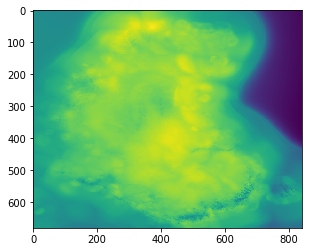

In [173]:
plt.imshow(dat)

In [178]:
x = np.rot90(dat, k = 3)

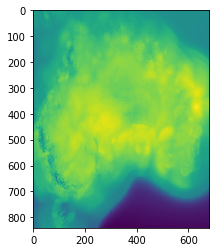

In [179]:
plt.imshow(x)

In [180]:
x.shape

(841, 681)

In [166]:
dat.shape

(1, 681, 841)

In [169]:
sp.Raster(src[0]).meta

{'driver': 'netCDF', 'dtype': 'float64', 'nodata': -999.0, 'width': 841, 'height': 681, 'count': 31, 'crs': CRS({'proj': 'longlat', 'ellps': 'WGS84', 'no_defs': True}), 'transform': Affine(0.05, 0.0, 111.975,
       0.0, -0.05, -9.975), 'blockxsize': 71, 'blockysize': 57, 'tiled': True}

In [181]:
import sys
sys.path.append('/home/war42q')
sys.path.append('/home/war42q')
from maclab.maclab import spatial as sp
from maclab.maclab import utils as ut
import rasterio
import pandas as pd
import icclim
from icclim import calc_indice

# nc files
src = '/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/rain_nc_files.txt'
with open(src) as f:
    src = f.readlines()
f.close()
src = [x.strip() for x in src] 
print('Reading in {0} files'.format(len(src)))

# dest
dst = '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_indicies/base-period-1960/TXx_1960C_small.tif'

Reading in 360 files


In [832]:
src[0]

'/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/tmax/nc/bom-tmax_day-19460101-19460131.nc'

In [833]:
# read into 3D arary
import numpy as np
base_period = np.dstack([sp.Raster(i).read(window = ((300, 310), (400, 412))).array for i in src[0:6]])

SystemError: <built-in function delete_Dataset> returned a result with an error set

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

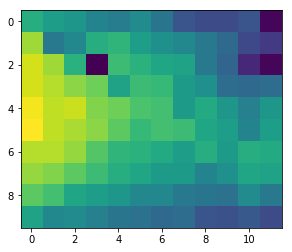

In [834]:
plt.imshow(base_period[:,:,0])

In [835]:
base_period_s = np.rollaxis(base_period, axis=-1)

In [836]:
base_period_s.shape

(181, 10, 12)

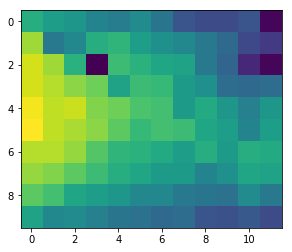

In [217]:
plt.imshow(base_period_s[0, :, :])

In [837]:
## calc SU
SU = calc_indice.SU_calculation(arr = base_period_s, fill_val = -9999)

In [844]:
base_period_s += 273.15

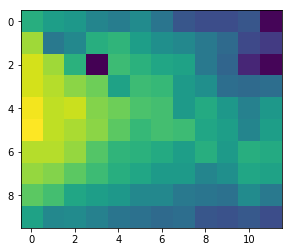

In [845]:
plt.imshow(base_period_s[0, :, :])

In [846]:
SU = calc_indice.SU_calculation(arr = base_period_s, fill_val = -9999)

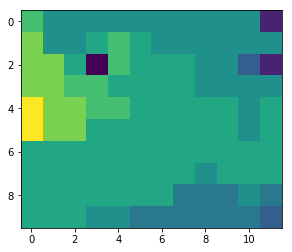

In [847]:
plt.imshow(SU)

In [135]:
# calc TXx
TXx = calc_indice.TXx_calculation(arr = base_period, fill_val = -9999)

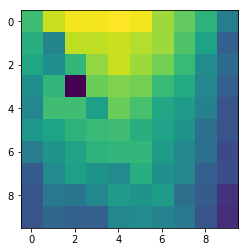

In [137]:
plt.imshow(TXx)

In [123]:
xx = np.arange(1, 13, 1).reshape(2,2,3)

In [125]:
xx[:, :, 1]

array([[ 2,  5],
       [ 8, 11]])

In [128]:
swp = np.swapaxes(xx, 2, 0)

In [132]:
xx

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])

In [133]:
swp[0, :, :]

array([[ 1,  7],
       [ 4, 10]])

In [ ]:
# write... optimistically
meta = sp.Raster(src[0]).meta
meta['count'] = 1
meta['dtype'] = 'float32'
meta['driver'] = 'GTiff'
meta['nodata'] = -9999

rm_keys = ['blockxsize', 'blockysize', 'tiled']
for k in rm_keys:
    if k in meta:
        del meta[k]

with rasterio.open(dst, 'w', **meta) as output:
    output.write(TXx.astype('float32'), 1)

In [23]:
from maclab.maclab import spatial as sp

In [31]:
src[0]

'/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/tmax/nc/bom-tmax_day-19460101-19460131.nc'

In [64]:
import rasterio
y = rasterio.open(src[0])

In [955]:
%%writefile test_argparse.py
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('-k', '--cel2kel', \
                    help='Convert input array from celsius to kelvin. ' + \
                    '<Optional> Set flag', action="store_true")
parser.add_argument("-v", "--verbose", action="store_true",
                    help="print messages to console")
parser.add_argument('-fn', '--filename', \
                    help='String to add to add to the filename. By default, the filename ' + \
                    'is given as <indicie>.tif. <Optional> Set flag')
args = parser.parse_args()

print(args)
print(vars(args))
if args.filename:
    print('RAH.{0}'.format(args.filename))

Overwriting test_argparse.py


In [957]:
%run test_argparse.py -v

Namespace(cel2kel=False, filename=None, verbose=True)
{'cel2kel': False, 'verbose': True, 'filename': None}


In [70]:
x.src.profile

{'driver': 'netCDF', 'dtype': 'float64', 'nodata': -999.0, 'width': 841, 'height': 681, 'count': 31, 'crs': CRS({'proj': 'longlat', 'ellps': 'WGS84', 'no_defs': True}), 'transform': Affine(0.05, 0.0, 111.975,
       0.0, -0.05, -9.975), 'blockxsize': 71, 'blockysize': 57, 'tiled': True}

In [34]:
x = sp.Raster(src[0]).read()

In [ ]:
#sys.getsizeof(object[, default]):

In [58]:
from matplotlib import pyplot as plt
%matplotlib inline

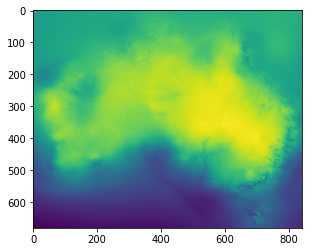

In [59]:
plt.imshow(x.array[:, :, 0])

In [14]:
!pip install --user git+https://github.com/cerfacs-globc/icclim.git

  Cloning https://github.com/cerfacs-globc/icclim.git to /tmp/pip-tvbdh3wd-build
  Running setup.py install for icclim ... done
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [89]:
import icclim
import importlib
importlib.reload(icclim)

<module 'icclim' from '/home/war42q/.local/lib/python3.6/site-packages/icclim/__init__.py'>

In [94]:
from icclim import calc_indice
calc_indice.TXx_calculation??

In [93]:
calc_indice.TXx_calculation??

** Calc extremes **
***
##### TX90p

In [545]:
## windows
start_year = 2017
end_year = 1901

window_starts = [start_year]
x = start_year
while x > end_year:
    window_starts.append(x - 10)
    x-=10
window_starts = window_starts[:-1]
window_ends = [i-14 for i in window_starts]
window_ends[-1] = end_year

windows = list(zip(window_ends, window_starts))[::-1]
windows = windows[2:]
print('Have set up the following first and last windows:\n%s, %s' %(windows[0], windows[-1]))

Have set up the following first and last windows:
(1913, 1927), (2003, 2017)


In [546]:
by_window = []
for win in windows:
    mn, mx = str(win[0]), str(win[1])
    this_win = []
    for yr in by_year.keys():
        if yr >= mn and yr <= mx:
            this_win.append({yr:by_year[yr]})
    by_window.append(this_win)
allwindows = all([len(i) for i in by_window]) 
tally = []
for i in by_window:
    kys = sum([list(i[y].keys()) for y in range(len(by_window[0]))],[]) 
    x = 0
    for y in range(len(kys)):
        x+=len(i[y][kys[y]])
    tally.append(x)
if all(tally) and allwindows:
    print('All {0} windows now have {1} files'.format(len(by_window), tally[0]))

All 10 windows now have 180 files


In [617]:
#x = rasterio.open(testfile)

In [564]:
from rasterio.crs import CRS
crs = CRS(init='epsg:4283')
#for win in by_window:
win = by_window[0]
kys = sum([list(win[y].keys()) for y in range(len(win))],[])
for y in range(len(kys)):
    this_yr = win[y][kys[y]]
    monthly = [sp.Raster(month).read().array for month in this_yr]
    monthly_totals = [np.sum(month, axis = 2) for month in monthly]
    year_total = np.sum(np.dstack(monthly_totals), axis = 2)
template_path = win[y][kys[y]][0]
aff = sp.Raster(template_path).meta['transform']
asRaster = sp.Raster(year_total, affine = aff)
fname = os.path.basename(template_path).split('_')[0]
dst = os.path.dirname(os.path.dirname(template_path))
dst = '{0}/tif/{1}_annual_total.tif'.format(dst, fname)
asRaster.write(dst)
        
        

TypeError: invalid path or file: {'1927': ['/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19270101-19270131.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19270201-19270228.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19270301-19270331.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19270401-19270430.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19270501-19270531.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19270601-19270630.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19270701-19270731.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19270801-19270831.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19270901-19270930.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19271001-19271031.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19271101-19271130.nc', '/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/nc/bom-rain_day-19271201-19271231.nc']}

***
***

In [ ]:
## See packages:
## trefoil
## ocgis 

In [2]:
#!pip install --user trefoil

In [8]:
%run startup.py

In [10]:
nc_src = admin.listfiles(var_dir, '.nc')[0]
nc_src

'/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/rain/bom-rain_day-19400501-19400531.nc'

In [31]:
x = sp.Raster(nc_src).read()

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
from trefoil.netcdf import describe
from trefoil.netcdf import conversion as cv

In [20]:
#describe.describe(nc_src)

In [21]:
dst = '%s/tif/%s.tif'%(var_dir, os.path.basename(nc_src)[:-3])
#cv.netcdf_to_raster(nc_src, variable_name = 'rain_day', outfilename = dst, index = 0, projection = prj)

In [22]:
from trefoil.netcdf import crs

In [23]:
from netCDF4 import Dataset
from pyproj import Proj, pj_list, pj_ellps, pyproj_datadir

In [41]:
ds = Dataset(nc_src, 'r')

In [52]:
prj = Proj(crs.get_crs(ds, 'rain_day'))

In [24]:
from maclab.maclab import spatial as sp

In [72]:
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
import xarray

In [26]:
xs = xarray.open_dataset(nc_src)

In [27]:
xs

<xarray.Dataset>
Dimensions:      (latitude: 681, longitude: 841, nv: 2, time: 31)
Coordinates:
  * time         (time) datetime64[ns] 1940-05-01 1940-05-02 1940-05-03 ...
  * latitude     (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude    (longitude) float64 112.0 112.0 112.1 112.2 112.2 112.2 ...
Dimensions without coordinates: nv
Data variables:
    rain_day     (time, latitude, longitude) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    crs          int32 -2147483647
    time_bounds  (time, nv) float64 5.125e+04 5.125e+04 5.125e+04 5.126e+04 ...
    lat_bounds   (latitude, nv) float64 -9.975 -10.03 -10.03 -10.08 -10.07 ...
    lon_bounds   (longitude, nv) float64 112.0 112.0 112.0 112.1 112.1 112.1 ...
Attributes:
    Conventions:                CF-1.6
    title:                      Australian Gridded Climate Data
    summary:                    The AGDC is a high-quality set of historical ...
    license:                    Copyright for any data supplied by th

In [28]:
dat = xs.to_array()
# array with the following dims: [var, month, lon, lat, nv]

In [33]:
## generate this

#a = width of a pixel
#b = row rotation (typically zero)
#c = x-coordinate of the upper-left corner of the upper-left pixel
#d = column rotation (typically zero)
#e = height of a pixel (typically negative)
#f = y-coordinate of the of the upper-left corner of the upper-left pixel


In [61]:
def affineFromXarray(x):
    a = float(x.geospatial_lon_resolution.split(' ')[0])
    b = 0
    c = x.geospatial_lon_min
    d = 0
    e = -float(x.geospatial_lat_resolution.split(' ')[0])
    f = x.geospatial_lat_max

c = c-(a/2)
f = f-(e/2)

In [62]:
from affine import Affine

In [63]:
Affine(a, b, c, d, e, f)

Affine(0.05, 0.0, 111.975,
       0.0, -0.05, -9.975)

In [64]:
x.affine

Affine(0.05, 0.0, 111.975,
       0.0, -0.05, -9.974999999999994)

0.025

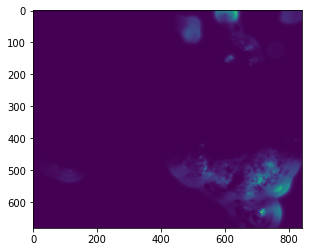

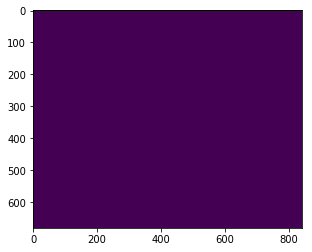

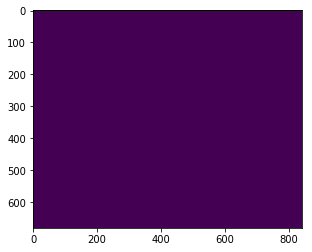

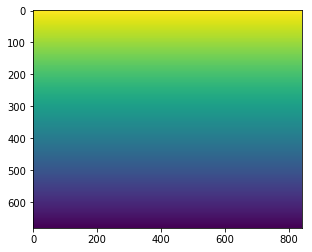

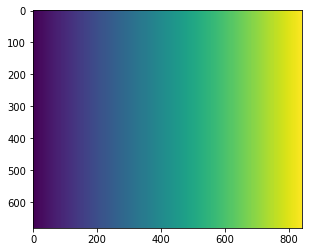

In [145]:
for i in range(5):
    plt.figure()
    plt.imshow(dat[i, 0, :, :, 0])
    plt.show()

In [140]:
dat

<xarray.DataArray (variable: 5, time: 31, latitude: 681, longitude: 841, nv: 2)>
array([[[[[  0.   ,   0.   ],
          ...,
          [  2.5  ,   2.5  ]],

         ...,

         [[  0.   ,   0.   ],
          ...,
          [  0.   ,   0.   ]]],


        ...,


        [[[  0.   ,   0.   ],
          ...,
          [  0.6  ,   0.6  ]],

         ...,

         [[  0.   ,   0.   ],
          ...,
          [  0.   ,   0.   ]]]],



       ...,



       [[[[111.975, 112.025],
          ...,
          [153.975, 154.025]],

         ...,

         [[111.975, 112.025],
          ...,
          [153.975, 154.025]]],


        ...,


        [[[111.975, 112.025],
          ...,
          [153.975, 154.025]],

         ...,

         [[111.975, 112.025],
          ...,
          [153.975, 154.025]]]]])
Coordinates:
  * time       (time) datetime64[ns] 1940-05-01 1940-05-02 1940-05-03 ...
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitud

In [90]:
d = np.ma.array(d, mask = (d==0))

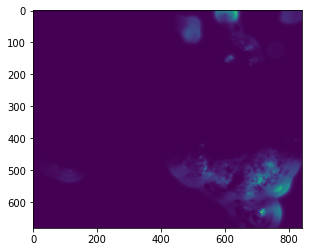

In [114]:
plt.imshow(d.array)

** From local as flts **

In [105]:
import importlib
importlib.reload(sp)

<module 'maclab.maclab.spatial' from '/home/war42q/maclab/maclab/spatial.py'>

In [46]:
flt_dirs = admin.listdirs('%s/SOURCE/clim/awap_daily/tmax' %RECA)
flts = [admin.listfiles(d, '.flt') for d in flt_dirs]

In [47]:
flts = sum(flts, [])

In [48]:
flts.sort(key = tokenize)

In [49]:
flts[0]

'/OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily/tmax/1900/bom-tmax-day-19000208-19000208.flt'

In [50]:
x = sp.Raster(flts[0])

In [51]:
x.affine

Affine(0.05, 0.0, 111.975,
       0.0, -0.05, -9.974999999999994)

**Wrong turns**

In [ ]:
%%writefile /OSM/CBR/LW_BACKCAST/work/code/reca/awap_daily_dwnld.sh
#!/usr/bin/env bash

if [[ $# -eq 0 ]] ; then
    echo "Usage: $0 param1"
    echo "* param1: climate variable which matches options here: http://rs-data1-mel.csiro.au/thredds/catalog/bawap/"
    echo "* returns: downloaded files to a dir named and created by param1 in the current dir"
    exit 0
fi

var=$1

cd /OSM/CBR/LW_BACKCAST/work/SOURCE/clim/awap_daily

if [ ! -d "$var" ]; then
  mkdir $var
fi

cd $var

for year in $(seq 1900 2018); do 
    URL=http://rs-data1-mel.csiro.au/thredds/catalog/bawap/$var/day/$year/catalog.html
    wget -r -nd -nc -np -e robots=off -A.nc --no-check-certificate $URL
done

In [ ]:
!chmod +x /OSM/CBR/LW_BACKCAST/work/code/reca/awap_daily_dwnld.sh

In [ ]:
# variable selection:
#https://github.com/BCCVL/org.bccvl.compute/blob/develop/src/org/bccvl/compute/rscripts/eval.R
#https://support.bccvl.org.au/support/solutions/articles/6000176035-variable-importance

In [694]:
nc = '/OSM/CBR/LW_GPAAG/work/LU/G/SOURCE/LUH2/PREDICTS_age_of_secd/secd-historical.nc'

In [695]:
import xarray

In [697]:
dat = xarray.open_dataset(nc, decode_times=False)

In [703]:
dat

<xarray.Dataset>
Dimensions:  (bins: 52, lat: 720, lon: 1440, time: 1166)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * lat      (lat) float32 89.875 89.625 89.375 89.125 88.875 88.625 88.375 ...
  * lon      (lon) float32 -179.875 -179.625 -179.375 -179.125 -178.875 ...
Dimensions without coordinates: bins
Data variables:
    crs      |S1 b''
    secdyf   (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    secdif   (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    secdmf   (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    secdyn   (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    secdin   (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    secdmn   (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    binsf    (bins, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    binsn    (bins, lat, lon) float64 nan nan nan nan nan na

In [707]:
time = dat['time']

In [709]:
dat_now = dat.isel(time = 1165)

In [710]:
dat_now

<xarray.Dataset>
Dimensions:  (bins: 52, lat: 720, lon: 1440)
Coordinates:
    time     float64 1.165e+03
  * lat      (lat) float32 89.875 89.625 89.375 89.125 88.875 88.625 88.375 ...
  * lon      (lon) float32 -179.875 -179.625 -179.375 -179.125 -178.875 ...
Dimensions without coordinates: bins
Data variables:
    crs      |S1 b''
    secdyf   (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    secdif   (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    secdmf   (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    secdyn   (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    secdin   (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    secdmn   (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    binsf    (bins, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    binsn    (bins, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    Conventions:

In [729]:
from netCDF4 import Dataset

In [730]:
root = Dataset(nc,'r',format='NETCDF4')

In [778]:
variables = dict.fromkeys(['secdyf', 'secdif', 'secdmf', 'secdyn', 'secdin', 'secdmn'])

In [782]:
for v in variables.keys():
    variables[v] = root.variables[v][-2, :, :]

In [791]:
from affine import Affine
from rasterio.crs import CRS

In [793]:
#x res, row rotation, xmin, column rotation, y res, ymax
trans = Affine(0.25, 0, -180, 0, 0.25, 90)
crs = CRS(init='epsg:4326')

In [801]:
meta = {'count': 1, 'crs':crs, 'height':720, 'width':1440, 
        'driver':'EHdr', 'nodata': -9999, 'transform':trans, 
        'dtype':'float32'}
meta

{'count': 1,
 'crs': CRS({'init': 'epsg:4326'}),
 'driver': 'EHdr',
 'dtype': 'float32',
 'height': 720,
 'nodata': -9999,
 'transform': Affine(0.25, 0.0, -180.0,
       0.0, 0.25, 90.0),
 'width': 1440}

In [802]:
dst = '/OSM/CBR/LW_GPAAG/work/LU/G/SOURCE/LUH2/PREDICTS_age_of_secd/secd-historical-presentday-flts'

In [806]:
for v in variables.keys():
    this_dst = '{0}/{1}.flt'.format(dst, v)
    this_dat = np.array(variables[v].astype('float32'))
    sp.write_flt(this_dat, meta, this_dst)
    print('{0} done'.format(v))

secdyf done
secdif done
secdmf done
secdyn done
secdin done
secdmn done


In [809]:
%%writefile /OSM/CBR/LW_GPAAG/work/LU/G/SOURCE/LUH2/PREDICTS_age_of_secd/secd-historical-presentday-flts/README.txt

This directory contains .flt files created from:
    /OSM/CBR/LW_GPAAG/work/LU/G/SOURCE/LUH2/PREDICTS_age_of_secd/secd-historical-presentday-flts/secd-historical.nc  
    
Files are for the last time dimension (present day) in secd-historical.nc, and for each of the secondary forest / 
non-forest charaterisations. 

Created by Chris Ware on 21/08/2018

Overwriting /OSM/CBR/LW_GPAAG/work/LU/G/SOURCE/LUH2/PREDICTS_age_of_secd/secd-historical-presentday-flts/README.txt


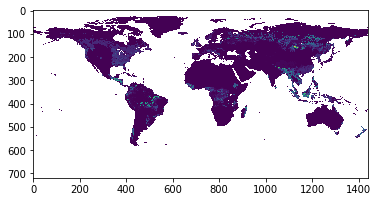

In [785]:
plt.imshow(variables['secdyf'])

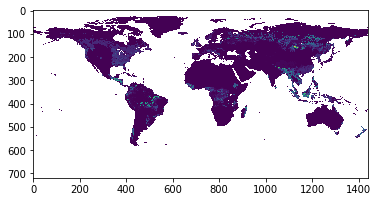

In [771]:
plt.imshow(secdyf[-2, :, :])

In [772]:
from homebaked import spatial as sp

In [773]:
sp.write_flt

<function homebaked.spatial.write_flt>

In [767]:
for i in range(binsf.shape[0]):
    print(np.mean(binsf[i, :, :]))

0.11092874285891104
0.001714462309724065
0.0013329323244631371
0.0015337936295545594
0.0010831034199778613
0.0018895267538819095
0.0013420179905461556
0.0009327201360336351
0.000911742082356893
0.0010524407724300058
0.0009874919288047452
0.0016601369388872422
0.0009328639070320387
0.0008994077582951702
0.0010297051241997097
0.0008779920175395443
0.0008013174568047519
0.0007604957002678996
0.0007691257374068806
0.0007266618280541089
0.0007276682250429336
0.0007052482119930408
0.0007456358226086055
0.0007825349208376202
0.000844567267066695
0.0008640599231704404
0.0007952516899197268
0.0007919973660888687
0.0007891686894010672
0.0007758810857144619
0.000770925353697242
0.0007653931212233696
0.0007312936621898679
0.00071395332167306
0.0007233196835148663
0.0007078245221828235
0.0006920059351236661
0.0006868965168667734
0.0006836891723933575
0.0006831402929659548
0.0006702660604094063
0.0006785287614670804
0.0006779265285985625
0.0006621308410251935
0.0006631934243812104
0.0006531183588658

In [762]:
secdyf_dat = secdyf[0, :, :]

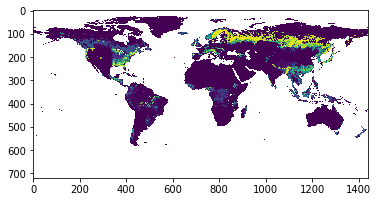

In [763]:
plt.imshow(secdyf_dat)

In [724]:
secdmf = dat_now['secdmf']

In [714]:
from matplotlib import pyplot as plt
%matplotlib inline

In [725]:
nn = np.array(secdyf)

In [726]:
np.max(nn)

/home/war42q/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


nan

/apps/python/3.6.1/lib/python3.6/site-packages/matplotlib-2.0.2-py3.6-linux-x86_64.egg/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/war42q/.local/lib/python3.6/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


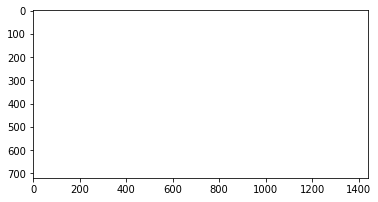

In [715]:
plt.imshow(secdyf)

In [705]:
dat['secdyf'] = dat.isel(x=slice(10, 1000)).load()

MemoryError: 

(512, 512)